In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.constants import c
from astropy.time import Time

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
fs = 1
freq_correction_tx = 13527500/8388593
gnuradio_correction = 1.6
f_sep = 245e3 + gnuradio_correction + freq_correction_tx
freq_correction_rx = 31/2**32 * f_sep
correction_remaining = freq_correction_tx + freq_correction_rx - gnuradio_correction

In [3]:
def open_file(filename, skip=0):
    data = {}
    x = np.fromfile(filename, 'uint8')
    x = x[:x.size//24*24].reshape(-1, 2, 12)
    data['f_offset'] = float(filename[:-len('_unwrap')].split('_')[-1])
    t0 = np.datetime64(filename.split('_')[2])
    data['t'] = t0 + (np.arange(x.shape[0]) / fs * 1e9) * np.timedelta64(1, 'ns')
    data['bpsk_phase'] = (
        x[:, 1, :8].ravel().view('int64').astype('float')
        + x[:, 1, 8:].ravel().view('float32').astype('float') / (2 * np.pi)
    )
    # apply frequency correction to diff_phase
    data['diff_phase'] = (
        x[:, 0, :8].ravel().view('int64').astype('float')
        + x[:, 0, 8:].ravel().view('float32').astype('float') / (2 * np.pi)
        - correction_remaining * np.arange(x.shape[0]) / fs
    )
    data['t'] = data['t'][skip:]
    data['bpsk_phase'] = data['bpsk_phase'][skip:]
    data['diff_phase'] = data['diff_phase'][skip:]
    return data

def range_km(data):
    return -1e-3 * data['diff_phase'][::fs] / f_sep * c

T_range_delta = 100
def range_delta(data, T_range_delta=T_range_delta):
    return np.diff(range_km(data)[::T_range_delta]) * 1e3 / T_range_delta

def remove_average(x):
    return x - np.nanmean(x)

In [4]:
filenames = [
    ('beacons_phases_2022-08-24T14:55:49.457364_tune_-130_unwrap', 100 * fs),
]
data = [open_file(filename, skip) for filename, skip in filenames]

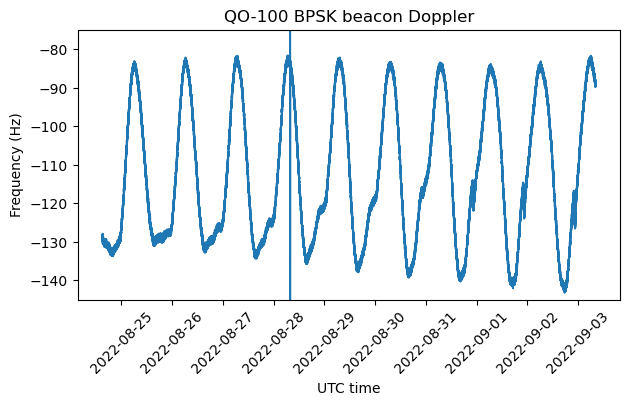

In [5]:
T_freq = 10
for d in data:
    f_doppler = np.diff(d['bpsk_phase'][::T_freq*fs])/T_freq + d['f_offset']
    plt.plot(d['t'][::T_freq*fs][:-1], f_doppler, color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Frequency (Hz)')
plt.title('QO-100 BPSK beacon Doppler')
plt.ylim(-145, -75);

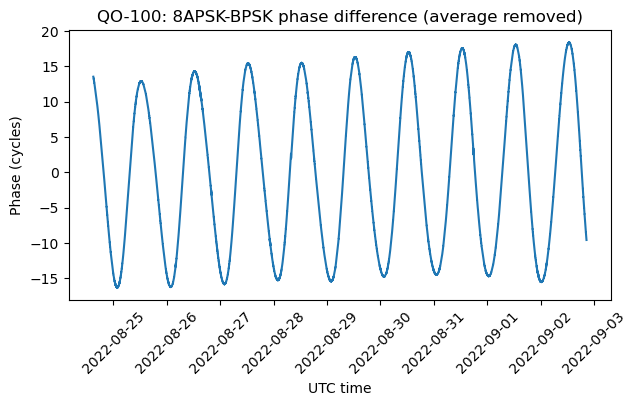

In [6]:
# Mask a portion of the phase difference due to the 8APSK beacon
# being out of service.
mask_diff_phase = d['t'] >= np.datetime64('2022-09-02T20:35:00')
d['diff_phase'][mask_diff_phase] = np.nan

for d in data:
    plt.plot(d['t'][::fs], remove_average(d['diff_phase'][::fs]),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)')
plt.title('QO-100: 8APSK-BPSK phase difference (average removed)');

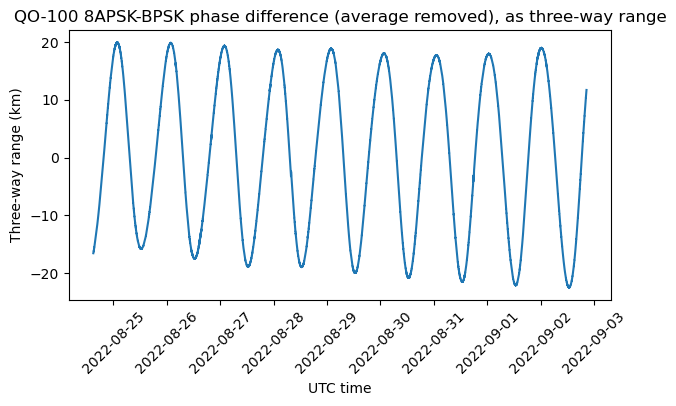

In [7]:
for d in data:
    plt.plot(d['t'][::fs], remove_average(range_km(d)), color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range (km)')
plt.title('QO-100 8APSK-BPSK phase difference (average removed), as three-way range');

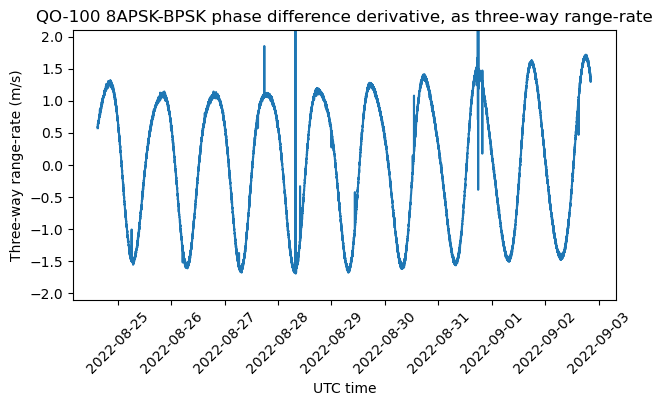

In [8]:
for d in data:
    plt.plot(d['t'][::fs*T_range_delta][:-1], range_delta(d),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range-rate (m/s)')
plt.title('QO-100 8APSK-BPSK phase difference derivative, as three-way range-rate')
plt.ylim((-2.1, 2.1));

## GMAT output

In [9]:
# Write GMD file for GMAT

with open('/tmp/qo100_range.gmd', 'w') as gmd:
    for d in data[1:]:
        for t, r in zip(d['t'][::fs][::100], remove_average(range_km(d))[::100] + 76.984e3):
            if not np.isnan(r):
                tai_mjd = Time(t).tai.jd - 2430000.0
                print(f'{tai_mjd}\tRange\t9015\t{{ 90001 43700 90002 }}\t{r}',
                      file=gmd)
            
with open('/tmp/qo100.gmd', 'w') as gmd:
    for d in data:
        for t, rr in zip(d['t'][::fs*T_range_delta][:-1], range_delta(d)):
            if not np.isnan(rr):
                t = t + T_range_delta  # adjust timestamp to end of interval
                rr = rr * 1e-3  # convert from m/s to km/s
                tai_mjd = Time(t).tai.jd - 2430000.0
                print(f'{tai_mjd}\tRangeRate\t9010\t{{ 90001 43700 90002 }}\t1\t{T_range_delta}\t{rr}',
                      file=gmd)